In [2]:
import pandas as pd
import numpy as np

vti = pd.read_csv('VTI.csv')
bnd = pd.read_csv('BND.csv')
blv = pd.read_csv('BLV.csv')
vti['Date'] = pd.to_datetime(vti['Date'],format='%Y-%m-%d')
bnd['Date'] = pd.to_datetime(bnd['Date'],format='%Y-%m-%d')
blv['Date'] = pd.to_datetime(blv['Date'],format='%Y-%m-%d')
# vti = vti.set_index('Date')
# bnd = bnd.set_index('Date')
# blv = blv.set_index('Date')

In [124]:
vti.iloc[0]

Date         2007-04-10 00:00:00
Open                      71.975
High                       72.14
Low                        71.94
Close                     72.115
Adj Close                56.0392
Volume                    237600
Name: 1459, dtype: object

In [3]:
class rebalance(object):
    def __init__(self, cash, stock_ratio, rebalance_thresh, start_date):
        self.cash = cash
        self.stock_ratio = stock_ratio
        self.rebalance_thresh = rebalance_thresh
        self.date = start_date
        self.rebalance_num = 0

        stock_price = vti.iloc[self.date]['Adj Close']
        bond_price = blv.loc[self.date]['Adj Close']
        cost = self.cash * self.stock_ratio
        self.cash -= cost
        self.stock = (cost - 10.0 - 0.002 * cost) / stock_price
        cost = self.cash
        self.cash -= cost
        self.bond = (cost - 10.0 - 0.002 * cost) / bond_price
    
    def iter(self):
        prev_date = self.date
        self.date = self.date + 1
        stock_price = vti.iloc[self.date]['Adj Close']
        bond_price = blv.loc[self.date]['Adj Close']
        stock_ratio = self.stock * stock_price / (self.stock * stock_price + self.bond * bond_price)

        if stock_ratio > self.stock_ratio + self.rebalance_thresh:
            self.rebalance_num += 1
            cash_diff = self.stock * stock_price - self.stock_ratio * (self.stock * stock_price + self.bond * bond_price)
            units = cash_diff / stock_price
            cash = (units * stock_price)*0.998 - 10.0
            self.stock -= units
            # bond_price = blv.loc[self.date+1]['Adj Close']
            self.bond += (cash - 10.0 - 0.002 * cash) / bond_price
        elif stock_ratio < self.stock_ratio - self.rebalance_thresh:
            self.rebalance_num += 1            
            cash_diff = self.stock_ratio * (self.stock * stock_price + self.bond * bond_price) - self.stock * stock_price 
            units = cash_diff / bond_price
            cash = (units * bond_price)*0.998 - 10.0
            self.bond -= units
            # stock_price = vti.iloc[self.date+1]['Adj Close']
            self.stock += (cash - 10.0 - 0.002 * cash) / stock_price

        return self.stock * stock_price + self.bond * bond_price

In [32]:
class sell_high(object):
    def __init__(self, cash, high_thresh, high_sell_ratio):
        self.cash = cash
        self.high_thresh = high_thresh
        self.high_sell_ratio = high_sell_ratio
        self.date = 0
        self.rebalance_num = 0
        self.sell_price = None
        self.sell_date = None

        cost = self.cash
        self.cash -= cost
        self.stock = (cost - 10.0 - 0.002 * cost) / vti.iloc[self.date].Close
    
    def iter(self):
        prev_date = self.date
        self.date = self.date + 1
        if self.cash > 0:
            # print("{} : Buy".format(self.date))
            # print(vti.iloc[prev_date])
            # print(vti.iloc[self.date])
            cost = self.cash
            self.cash -= cost
            buy_price = vti.iloc[self.date].Open
            # if vti.iloc[self.date].Low < self.sell_price * (1-self.high_thresh/3):
            #     buy_price = min([self.sell_price * (1-self.high_thresh/3), vti.iloc[self.date].Open])
            # else:
            #     buy_price = vti.iloc[self.date].Close
            self.stock += (cost - 10.0 - 0.002 * cost) / buy_price
        else:
            # print("{} : Sell".format(self.date))
            # print(vti.iloc[prev_date])
            # print(vti.iloc[self.date])
            prev_day_Stocks = self.stock
            for i in range(6, 9):
                percentage = (i+1.0) /100
                if vti.iloc[self.date].High > vti.iloc[prev_date].Close * (1+percentage):
                    self.rebalance_num += 1
                    self.sell_price = max([vti.iloc[self.date].Open, vti.iloc[prev_date].Close * (1+percentage)])
                    self.sell_date = self.date
                    units = prev_day_Stocks * 0.3
                    self.stock -= units
                    self.cash += (units * self.sell_price) * 0.998 - 10.0

        stock_price = vti.iloc[self.date].Close

        return self.stock * stock_price + self.cash

In [16]:
class rebalance_buy_low(object):
    def __init__(self, cash, stock_ratio, rebalance_thresh, buy_low_thresh, start_date):
        self.cash = cash
        self.stock_ratio = stock_ratio
        self.buy_low_thresh = buy_low_thresh
        self.rebalance_thresh = rebalance_thresh
        self.date = start_date
        self.rebalance_num = 0

        stock_price = vti.iloc[self.date].Close
        bond_price = blv.loc[self.date].Close
        cost = self.cash * self.stock_ratio
        self.cash -= cost
        self.stock = (cost - 10.0 - 0.002 * cost) / stock_price
        cost = self.cash
        self.cash -= cost
        self.bond = (cost - 10.0 - 0.002 * cost) / bond_price
    
    def iter(self):
        prev_date = self.date
        self.date = self.date + 1
        stock_price = vti.iloc[self.date].Close
        bond_price = blv.loc[self.date].Close
        stock_ratio = self.stock * stock_price / (self.stock * stock_price + self.bond * bond_price)

        if vti.iloc[self.date].Low < (vti.iloc[prev_date].Close * (1-self.buy_low_thresh)) and self.bond > 0:
            self.rebalance_num += 1
            cash = (self.bond * blv.loc[self.date].Low) * (1-0.002) - 10
            self.bond = 0
            buy_price = min([(vti.iloc[prev_date].Close * (1-self.buy_low_thresh)), vti.iloc[self.date].Open])
            self.stock += (cash - 10.0 - 0.002 * cash) / buy_price
        elif stock_ratio > self.stock_ratio + self.rebalance_thresh:
            self.rebalance_num += 1
            sell_units = self.stock * (1-self.stock_ratio)
            sell_price = (vti.iloc[self.date].Open + vti.iloc[self.date].Close)/2.0
            cash = (sell_units * sell_price)*0.998 - 10.0
            self.stock -= sell_units
            buy_price = (blv.iloc[self.date].Open + blv.iloc[self.date].Close)/2.0
            # bond_price = blv.loc[self.date+1]['Adj Close']
            self.bond += (cash - 10.0 - 0.002 * cash) / buy_price

        return self.stock * stock_price + self.bond * bond_price

In [33]:
cash = 100000
stock_ratio = 0.6

start_date = max([bnd.Date.min(), vti.Date.min(), blv.Date.min()])
vti = vti.iloc[np.flatnonzero(vti.Date == start_date)[0]:]
bnd = bnd.iloc[np.flatnonzero(bnd.Date == start_date)[0]:]
blv = blv.iloc[np.flatnonzero(blv.Date == start_date)[0]:]
start_date = bnd.index.min()

stock = 0
bond = 0

# invest = rebalance(cash=100000, stock_ratio=0., rebalance_thresh=0.1, start_date=start_date)
# invest = rebalance_buy_low(cash=100000, stock_ratio=0.6, rebalance_thresh=0.05, buy_low_thresh=0.07, start_date=start_date)
invest = sell_high(cash=100000, high_thresh=0.04, high_sell_ratio=0.3)
val = []
while invest.date < bnd.index.max():
    val.append(invest.iter())

print(invest.rebalance_num, val[-1])


8 171444.49814649767


In [281]:
start_date

100

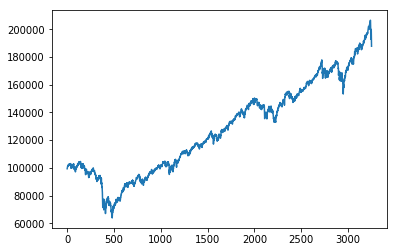

In [106]:
import matplotlib.pyplot as plt
plt.plot(val)

In [ ]:
            if self.date - self.sell_date > 5:
                buy_price = (vti.iloc[self.date].Open + vti.iloc[self.date].Close) / 2.0
                cost = self.cash
                self.cash -= cost
                self.stock += (cost - 10.0 - 0.002 * cost) / buy_price
            elif vti.iloc[self.date].Low < self.sell_price * 0.99:
                buy_price = min([vti.iloc[self.date].Open, self.sell_price * 0.99])
                cost = self.cash
                self.cash -= cost
                self.stock += (cost - 10.0 - 0.002 * cost) / buy_price
